In [1]:
import numpy as np
from tqdm import tqdm_notebook
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
from copy import copy
from collections import defaultdict
from scipy.spatial import distance
from sklearn.metrics import calinski_harabaz_score, silhouette_score, davies_bouldin_score, pairwise_distances
from sklearn.cluster import DBSCAN, KMeans, SpectralClustering
from scipy.spatial import distance
from IPython.core.debugger import set_trace

In [6]:
ls -la separate_datasets_transformed_data

total 15580
drwxrwxr-x  2 ibulygin ibulygin    4096 нояб.  9 10:19 ./
drwxrwxr-x 11 ibulygin ibulygin    4096 нояб.  9 10:27 ../
-rw-rw-r--  1 ibulygin ibulygin 2183858 нояб.  9 10:19 AGP_proj_f_isomap.csv
-rw-rw-r--  1 ibulygin ibulygin 2183024 нояб.  9 10:19 AGP_proj_f_lle.csv
-rw-rw-r--  1 ibulygin ibulygin 2183103 нояб.  9 10:19 AGP_proj_g_isomap.csv
-rw-rw-r--  1 ibulygin ibulygin 2183552 нояб.  9 10:19 AGP_proj_g_lle.csv
-rw-rw-r--  1 ibulygin ibulygin 1456241 нояб.  9 10:19 AGP_proj_o_isomap.csv
-rw-rw-r--  1 ibulygin ibulygin 1459285 нояб.  9 10:19 AGP_proj_o_lle.csv
-rw-rw-r--  1 ibulygin ibulygin    8793 нояб.  9 10:19 ibd_proj_f_isomap.csv
-rw-rw-r--  1 ibulygin ibulygin    8750 нояб.  9 10:19 ibd_proj_f_lle.csv
-rw-rw-r--  1 ibulygin ibulygin   11013 нояб.  9 10:19 ibd_proj_g_isomap.csv
-rw-rw-r--  1 ibulygin ibulygin   10991 нояб.  9 10:19 ibd_proj_g_lle.csv
-rw-rw-r--  1 ibulygin ibulygin    6604 нояб.  9 10:19 ibd_proj_o_isomap.csv
-rw-rw-r--  1 ibulygin ibulygin    6590

In [7]:
# paths to the databases containing the PCA and Isomap projections 
root_pca = './separate_datasets_data'
root_mf = './separate_datasets_transformed_data/'

paths = [os.path.join(root_pca,path) for path in os.listdir(root_pca)]
paths_mf = [os.path.join(root_mf,path) for path in os.listdir(root_mf)]

paths_pca = list(filter(lambda x: 'err' not in x.split("/")[-1].split(".")[0].split('_'), paths))

paths_mf_lle = list(filter(lambda x: 'lle' in x.split("/")[-1].split(".")[0].split('_'), paths_mf))
paths_mf_isomap = list(filter(lambda x: 'isomap' in x.split("/")[-1].split(".")[0].split('_'), paths_mf))

In [14]:
label2path = {}
for path in paths_pca + paths_mf_lle + paths_mf_isomap:
    label = path.split("/")[-1].split(".")[0]
    label_split = label.split('_')[:4]
    label = '_'.join(label_split)
    label2path[label] = path

In [15]:
label2path

{'ptb_proj_f': './separate_datasets_data/ptb_proj_f.csv',
 'AGP_proj_o': './separate_datasets_data/AGP_proj_o.csv',
 't2d_proj_f': './separate_datasets_data/t2d_proj_f.csv',
 'ibd_proj_o': './separate_datasets_data/ibd_proj_o.csv',
 't2d_proj_g': './separate_datasets_data/t2d_proj_g.csv',
 'ptb_proj_g': './separate_datasets_data/ptb_proj_g.csv',
 'ptb_proj_o': './separate_datasets_data/ptb_proj_o.csv',
 'AGP_proj_f': './separate_datasets_data/AGP_proj_f.csv',
 'AGP_proj_g': './separate_datasets_data/AGP_proj_g.csv',
 'ibd_proj_f': './separate_datasets_data/ibd_proj_f.csv',
 't2d_proj_o': './separate_datasets_data/t2d_proj_o.csv',
 'ibd_proj_g': './separate_datasets_data/ibd_proj_g.csv',
 't2d_proj_o_lle': './separate_datasets_transformed_data/t2d_proj_o_lle.csv',
 'AGP_proj_f_lle': './separate_datasets_transformed_data/AGP_proj_f_lle.csv',
 'ibd_proj_g_lle': './separate_datasets_transformed_data/ibd_proj_g_lle.csv',
 'ibd_proj_f_lle': './separate_datasets_transformed_data/ibd_proj_f_ll

# Distances, PCA

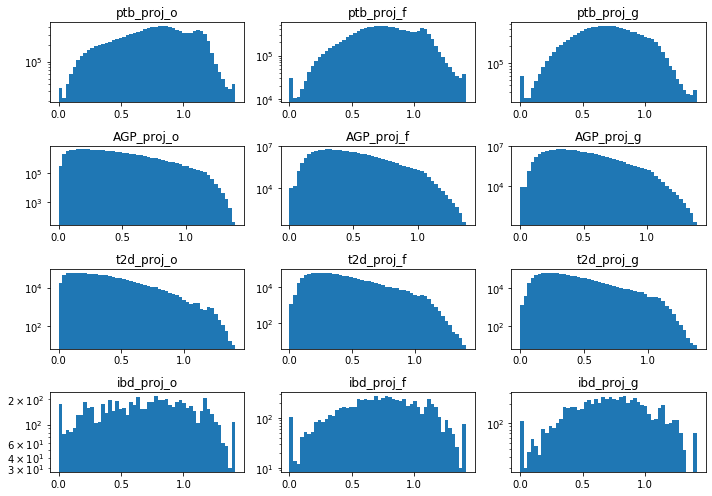

In [16]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10,7))
for i,dataset_name in enumerate(['ptb', 'AGP', 't2d', 'ibd']):
    for j,tax_name in enumerate(['o', 'f', 'g']):
        label = '_'.join([dataset_name, 'proj', tax_name])
        p = label2path[label]
        data = np.genfromtxt(p, delimiter=';')
        pdists = pairwise_distances(data).flatten()
        axes[i,j].hist(pdists, bins=50)
        axes[i,j].set_title(label)
        axes[i,j].set_yscale('log')

plt.tight_layout()
plt.show()

# Distances ISOMAP

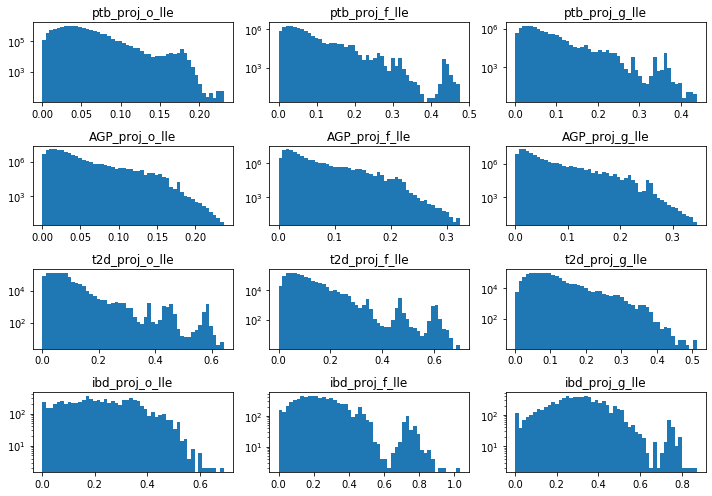

In [17]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10,7))
for i,dataset_name in enumerate(['ptb', 'AGP', 't2d', 'ibd']):
    for j,tax_name in enumerate(['o', 'f', 'g']):
        label = '_'.join([dataset_name, 'proj', tax_name, 'lle'])
        p = label2path[label]
        data = np.genfromtxt(p, delimiter=';')
        pdists = pairwise_distances(data).flatten()
        axes[i,j].hist(pdists, bins=50)
        axes[i,j].set_title(label)
        axes[i,j].set_yscale('log')
        
plt.tight_layout()
plt.show()

# Distances LLE

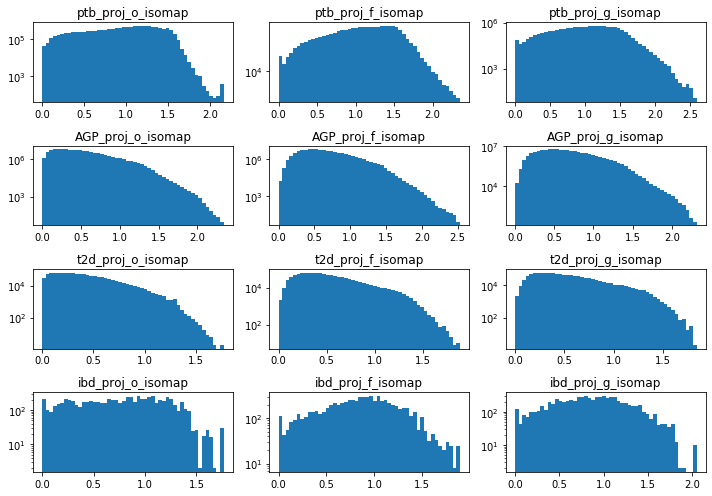

In [18]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10,7))
for i,dataset_name in enumerate(['ptb', 'AGP', 't2d', 'ibd']):
    for j,tax_name in enumerate(['o', 'f', 'g']):
        label = '_'.join([dataset_name, 'proj', tax_name, 'isomap'])
        p = label2path[label]
        data = np.genfromtxt(p, delimiter=';')
        pdists = pairwise_distances(data).flatten()
        axes[i,j].hist(pdists, bins=50)
        axes[i,j].set_title(label)
        axes[i,j].set_yscale('log')
        
plt.tight_layout()
plt.show()

# Functions

In [19]:
# Davies Bouldin Index
def DB_index(X, clusters_centers, labels):
    if -1 in labels:
        X = X[labels != -1]
        labels = labels[labels != -1]
    n_clusters = len(clusters_centers)
    d = np.array([distance.euclidean(X[i], clusters_centers[labels[i]]) for i in range(len(X))])
    mean_dist = np.zeros(n_clusters)
    for i in range(n_clusters):
        mean_dist[i] = d[labels == i].mean()
    return sum([max([(mean_dist[i] + mean_dist[j]) / distance.euclidean(clusters_centers[i], clusters_centers[j]) 
         for i in range(n_clusters) if i != j]) for j in range(n_clusters)]) / n_clusters

In [24]:
# Clusters centers
def cl_centers(X, pred, n_cl=None):
    if n_cl is None:
        n_cl = len(set(pred))
        if -1 in pred:
            n_cl -= 1
    centers = np.zeros((n_cl, X.shape[1]))
    for i in range(n_cl):
        centers[i] = X[pred == i].mean(0)
    return centers

In [30]:
# sample the data via binomial mask
def sample_data(data, fraction):
    mask = np.random.binomial(1, fraction, data.shape[0]).astype(bool)
    return data[mask]

In [31]:
def plot_proj_clustering(clustering_results, method='', suptitle=None):
    results = copy(clustering_results)
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20,15))
    for i,dataset_name in enumerate(['ptb', 'AGP', 't2d', 'ibd']):
        for j,tax_name in enumerate(['o', 'f', 'g']):
            label = f'{dataset_name}_proj_{tax_name}'
            
            if len(method) > 0:
                label += '_' + method
            
            names = results.keys() # clustering_results = {}
            
            if label in names:
                data = results[label]
                if len(data) > 0:
                    df = pd.DataFrame(data=data).T
                    df.columns = ['Davies-Bouldin index', 'silhouette_score', 'noise_ratio']
                    df.sort_index(ascending=False, inplace=True)
                    if df['noise_ratio'].sum() == 0.:
                        df.drop('noise_ratio', axis=1, inplace=True)
                    ax = axes[i,j]
                    ax.set_xlabel('# estimated clusters')
                    ax.set_title(label)
                    df.plot.bar(ax=ax)
    
    plt.tight_layout()
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16, color='blue')
    plt.show()

In [32]:
def clustering(paths, method_class, param_range):
    # performing clustering
    cluster_results = defaultdict(dict)
    for path in tqdm_notebook(paths):
        dataset = np.genfromtxt(path, delimiter=';')
        label = path.split("/")[-1].split(".")[0]
        for p in param_range:
            method = method_class(p)
            pred = method.fit_predict(dataset)
            if max(pred) > 0: # at least 2 clusters
                centers = cl_centers(dataset, pred)
                ind = davies_bouldin_score(dataset, pred)
                silh = silhouette_score(dataset, pred)
                n = len(np.unique(pred[pred != -1]))
                noise_ratio = sum(pred == -1)/len(pred)
                cluster_results[label][n] = [ind, silh, noise_ratio]
            else:
                print(f'Only one cluster was found for {label}, method: {method.__class__.__name__} param: {p}')
    return cluster_results

In [60]:
lle_cluster_results_list[0].keys()

dict_keys(['AGP_proj_f_lle', 'ibd_proj_g_lle', 'ibd_proj_f_lle', 'ptb_proj_f_lle', 'ptb_proj_o_lle', 't2d_proj_f_lle', 't2d_proj_g_lle', 'ibd_proj_o_lle', 'AGP_proj_g_lle', 'ptb_proj_g_lle', None])

In [61]:
def create_clustering_pivot_table(results_list, methods_names, datasets_names, manifold='', noise_threshold=0.3):
    all_results = dict(zip(methods_names, results_list))
    X_dbind =np.zeros((len(methods_names), len(datasets_names)))
    X_silh =np.zeros((len(methods_names), len(datasets_names)))

    for i,(method_name) in tqdm_notebook(enumerate(methods_names)): # dbscan, kmeans
        for j,(dataset_name) in enumerate(datasets_names):
            
            method_results_dict = all_results[method_name] # e.g. dbscan results
            names = method_results_dict.keys() # datasets names
            label = dataset_name + '_' + manifold
            results_dict = method_results_dict[label]
            if len(results_dict) == 0:
                n_dbind = 1
                n_silh = 1
            else:
                # filtering noise samples
                results_dict = {k:v for k,v in results_dict.items() if v[-1] < noise_threshold}
                if len(results_dict) > 0:
                    n_dbind = sorted(results_dict, key=lambda x: results_dict[x][0])[0] # minimized
                    n_silh = sorted(results_dict, key=lambda x: results_dict[x][1])[-1] # maximized
                else:
                    print(f'{method_name} couldnt estimate N clusters for {label} given threshold: {noise_threshold}')
                    n_dbind = np.nan
                    n_silh = np.nan
            
            X_dbind[i,j] = n_dbind
            X_silh[i,j] = n_silh
    X_dbind = pd.DataFrame(data = X_dbind, columns=datasets_names, index=methods_names)
    X_silh = pd.DataFrame(data = X_silh, columns=datasets_names, index=methods_names)
    return X_dbind, X_silh

# PCA clustering

In [34]:
methods_dict_PCA = {'dbscan':[DBSCAN, np.linspace(0.0001, 0.5, 50)],
                   'KMeans':[KMeans, np.arange(2, 15, 1)]} # 'SpectralClustering':[SpectralClustering, np.arange(2, 15, 1)]
                    


dbscan_results = clustering(paths_pca, *methods_dict_PCA['dbscan'])

kmeans_results = clustering(paths_pca, *methods_dict_PCA['KMeans'])

# spectral_results = clustering(paths_pca, *methods_dict_PCA['SpectralClustering'])

Only one cluster was found for ptb_proj_f, method: DBSCAN param: 0.0001
Only one cluster was found for ptb_proj_f, method: DBSCAN param: 0.40818163265306123
Only one cluster was found for ptb_proj_f, method: DBSCAN param: 0.41838367346938776
Only one cluster was found for ptb_proj_f, method: DBSCAN param: 0.4285857142857143
Only one cluster was found for ptb_proj_f, method: DBSCAN param: 0.4387877551020408
Only one cluster was found for ptb_proj_f, method: DBSCAN param: 0.44898979591836735
Only one cluster was found for ptb_proj_f, method: DBSCAN param: 0.4591918367346939
Only one cluster was found for ptb_proj_f, method: DBSCAN param: 0.4693938775510204
Only one cluster was found for ptb_proj_f, method: DBSCAN param: 0.47959591836734694
Only one cluster was found for ptb_proj_f, method: DBSCAN param: 0.4897979591836735
Only one cluster was found for ptb_proj_f, method: DBSCAN param: 0.5
Only one cluster was found for AGP_proj_o, method: DBSCAN param: 0.0001
Only one cluster was found 

Only one cluster was found for t2d_proj_g, method: DBSCAN param: 0.15313061224489796
Only one cluster was found for t2d_proj_g, method: DBSCAN param: 0.1633326530612245
Only one cluster was found for t2d_proj_g, method: DBSCAN param: 0.17353469387755102
Only one cluster was found for t2d_proj_g, method: DBSCAN param: 0.18373673469387755
Only one cluster was found for t2d_proj_g, method: DBSCAN param: 0.19393877551020408
Only one cluster was found for t2d_proj_g, method: DBSCAN param: 0.2041408163265306
Only one cluster was found for t2d_proj_g, method: DBSCAN param: 0.21434285714285714
Only one cluster was found for t2d_proj_g, method: DBSCAN param: 0.22454489795918367
Only one cluster was found for t2d_proj_g, method: DBSCAN param: 0.2347469387755102
Only one cluster was found for t2d_proj_g, method: DBSCAN param: 0.24494897959183676
Only one cluster was found for t2d_proj_g, method: DBSCAN param: 0.2551510204081633
Only one cluster was found for t2d_proj_g, method: DBSCAN param: 0.26

Only one cluster was found for AGP_proj_g, method: DBSCAN param: 0.27555510204081635
Only one cluster was found for AGP_proj_g, method: DBSCAN param: 0.2857571428571429
Only one cluster was found for AGP_proj_g, method: DBSCAN param: 0.2959591836734694
Only one cluster was found for AGP_proj_g, method: DBSCAN param: 0.30616122448979594
Only one cluster was found for AGP_proj_g, method: DBSCAN param: 0.31636326530612247
Only one cluster was found for AGP_proj_g, method: DBSCAN param: 0.326565306122449
Only one cluster was found for AGP_proj_g, method: DBSCAN param: 0.3367673469387755
Only one cluster was found for AGP_proj_g, method: DBSCAN param: 0.34696938775510205
Only one cluster was found for AGP_proj_g, method: DBSCAN param: 0.3571714285714286
Only one cluster was found for AGP_proj_g, method: DBSCAN param: 0.3673734693877551
Only one cluster was found for AGP_proj_g, method: DBSCAN param: 0.37757551020408164
Only one cluster was found for AGP_proj_g, method: DBSCAN param: 0.38777

Only one cluster was found for ibd_proj_g, method: DBSCAN param: 0.08171632653061225
Only one cluster was found for ibd_proj_g, method: DBSCAN param: 0.09191836734693878
Only one cluster was found for ibd_proj_g, method: DBSCAN param: 0.30616122448979594
Only one cluster was found for ibd_proj_g, method: DBSCAN param: 0.31636326530612247
Only one cluster was found for ibd_proj_g, method: DBSCAN param: 0.326565306122449
Only one cluster was found for ibd_proj_g, method: DBSCAN param: 0.3367673469387755
Only one cluster was found for ibd_proj_g, method: DBSCAN param: 0.34696938775510205
Only one cluster was found for ibd_proj_g, method: DBSCAN param: 0.3571714285714286
Only one cluster was found for ibd_proj_g, method: DBSCAN param: 0.3673734693877551
Only one cluster was found for ibd_proj_g, method: DBSCAN param: 0.37757551020408164
Only one cluster was found for ibd_proj_g, method: DBSCAN param: 0.3877775510204082
Only one cluster was found for ibd_proj_g, method: DBSCAN param: 0.3979

# DBSCAN: PCA

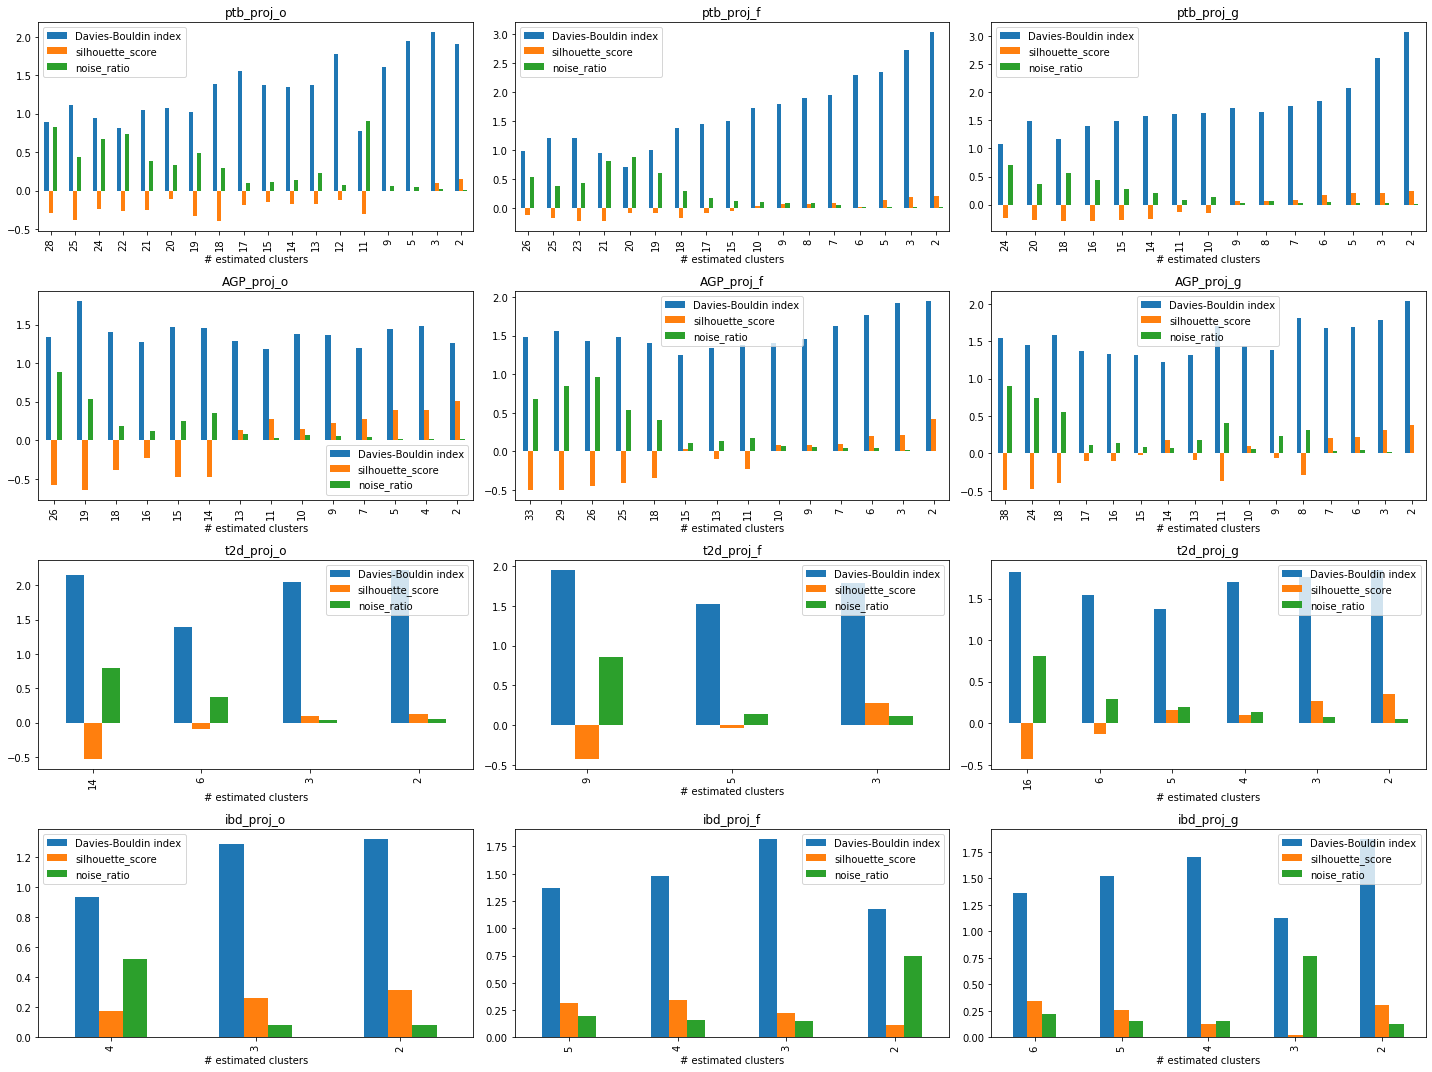

In [35]:
plot_proj_clustering(dbscan_results)

# KMEANS: PCA

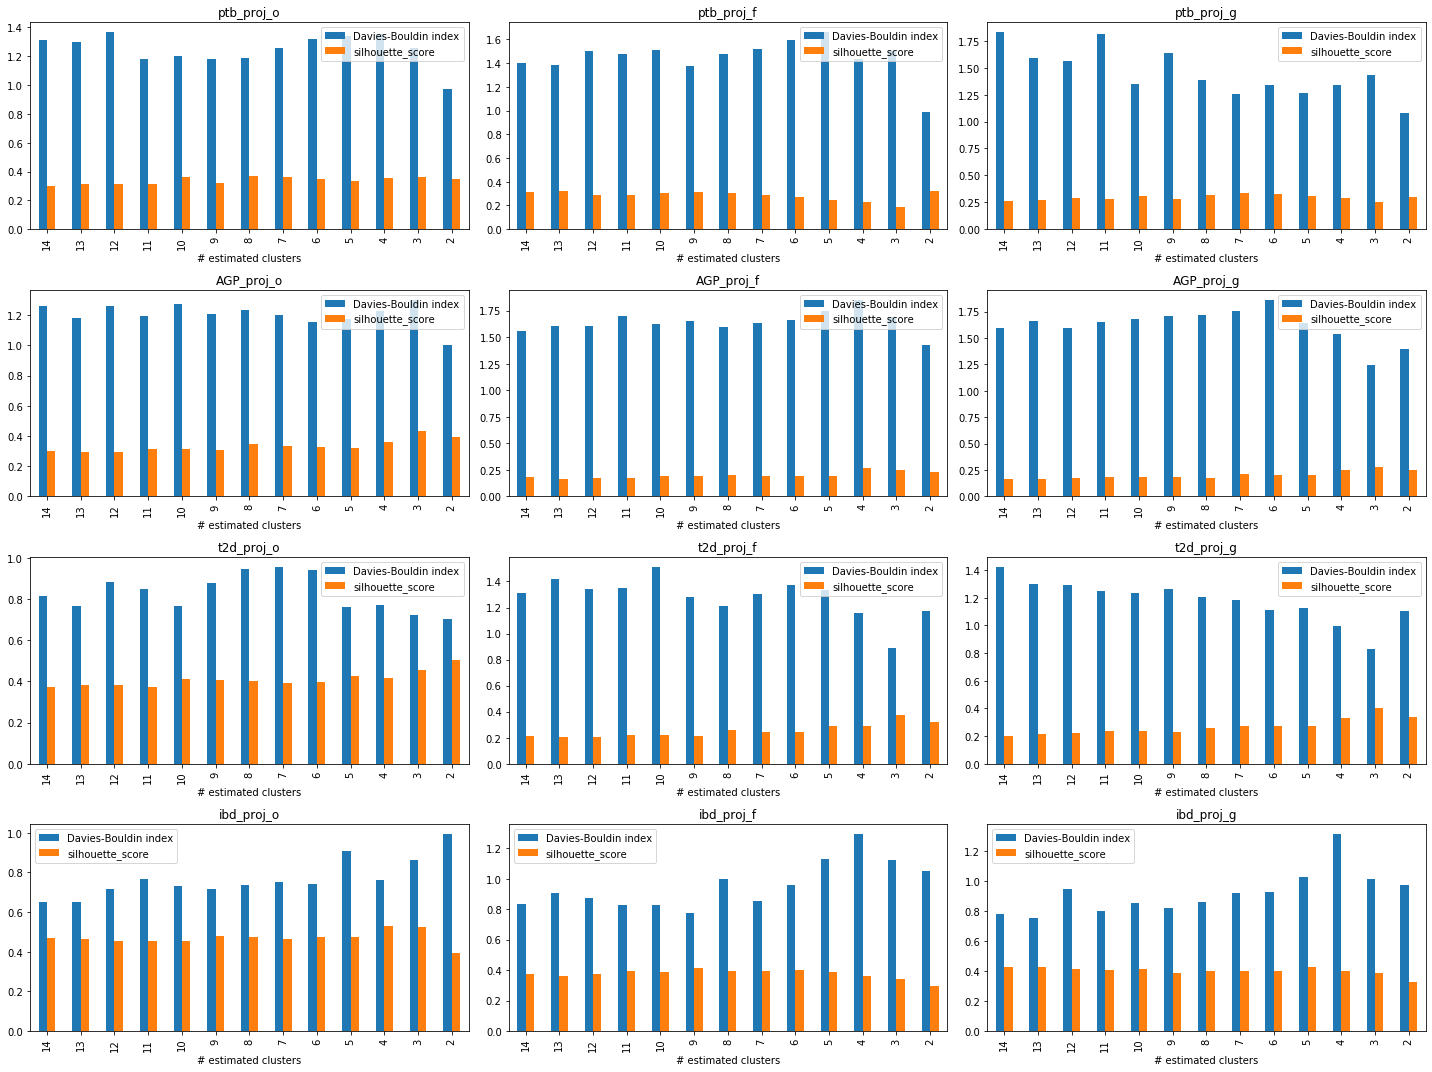

In [36]:
plot_proj_clustering(kmeans_results)

# SPECTRAL: PCA

In [37]:
# plot_proj_clustering(spectral_results)


# Aggregation

In [38]:
methods_names = list(methods_dict_PCA.keys())
datasets_names = sorted(list(dbscan_results.keys()))

X_dbind, X_silh = create_clustering_pivot_table([dbscan_results, kmeans_results], methods_names, datasets_names)

In [39]:
X_dbind

,AGP_proj_f,AGP_proj_g,AGP_proj_o,ibd_proj_f,ibd_proj_g,ibd_proj_o,ptb_proj_f,ptb_proj_g,ptb_proj_o,t2d_proj_f,t2d_proj_g,t2d_proj_o
dbscan,15.0,14.0,11.0,5.0,6.0,3.0,18.0,15.0,14.0,5.0,5.0,3.0
KMeans,2.0,3.0,2.0,9.0,13.0,13.0,2.0,2.0,2.0,3.0,3.0,2.0


In [40]:
X_silh

,AGP_proj_f,AGP_proj_g,AGP_proj_o,ibd_proj_f,ibd_proj_g,ibd_proj_o,ptb_proj_f,ptb_proj_g,ptb_proj_o,t2d_proj_f,t2d_proj_g,t2d_proj_o
dbscan,2.0,2.0,2.0,4.0,6.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0
KMeans,4.0,3.0,3.0,9.0,5.0,4.0,13.0,7.0,8.0,3.0,3.0,2.0


# For ISOMAP

In [41]:
methods_dict_ISOMAP = {'dbscan':[DBSCAN, np.linspace(0.0001, 0.3, 50)],
                       'KMeans':[KMeans, np.arange(2, 15, 1)]} # 'SpectralClustering':[SpectralClustering, np.arange(2, 15, 1)]

methods_names = list(methods_dict_ISOMAP.keys())

isomap_cluster_results_list = []
for method_name in methods_names:
    method_class, param_range = methods_dict_ISOMAP[method_name]
    cluster_results = clustering(paths_mf_isomap, method_class, param_range)
    isomap_cluster_results_list.append(cluster_results)

Only one cluster was found for AGP_proj_o_isomap, method: DBSCAN param: 0.0001
Only one cluster was found for AGP_proj_o_isomap, method: DBSCAN param: 0.2387959183673469
Only one cluster was found for AGP_proj_o_isomap, method: DBSCAN param: 0.2449163265306122
Only one cluster was found for AGP_proj_o_isomap, method: DBSCAN param: 0.25103673469387755
Only one cluster was found for AGP_proj_o_isomap, method: DBSCAN param: 0.2571571428571428
Only one cluster was found for AGP_proj_o_isomap, method: DBSCAN param: 0.2632775510204081
Only one cluster was found for AGP_proj_o_isomap, method: DBSCAN param: 0.26939795918367343
Only one cluster was found for AGP_proj_o_isomap, method: DBSCAN param: 0.27551836734693874
Only one cluster was found for AGP_proj_o_isomap, method: DBSCAN param: 0.28163877551020405
Only one cluster was found for AGP_proj_o_isomap, method: DBSCAN param: 0.28775918367346937
Only one cluster was found for AGP_proj_o_isomap, method: DBSCAN param: 0.2938795918367347
Only o

Only one cluster was found for t2d_proj_o_isomap, method: DBSCAN param: 0.17759183673469386
Only one cluster was found for t2d_proj_o_isomap, method: DBSCAN param: 0.18371224489795915
Only one cluster was found for t2d_proj_o_isomap, method: DBSCAN param: 0.18983265306122446
Only one cluster was found for t2d_proj_o_isomap, method: DBSCAN param: 0.19595306122448977
Only one cluster was found for t2d_proj_o_isomap, method: DBSCAN param: 0.20207346938775508
Only one cluster was found for t2d_proj_o_isomap, method: DBSCAN param: 0.2081938775510204
Only one cluster was found for t2d_proj_o_isomap, method: DBSCAN param: 0.21431428571428568
Only one cluster was found for t2d_proj_o_isomap, method: DBSCAN param: 0.220434693877551
Only one cluster was found for t2d_proj_o_isomap, method: DBSCAN param: 0.2265551020408163
Only one cluster was found for t2d_proj_o_isomap, method: DBSCAN param: 0.23267551020408161
Only one cluster was found for t2d_proj_o_isomap, method: DBSCAN param: 0.2387959183

# DBSCAN: ISOMAP

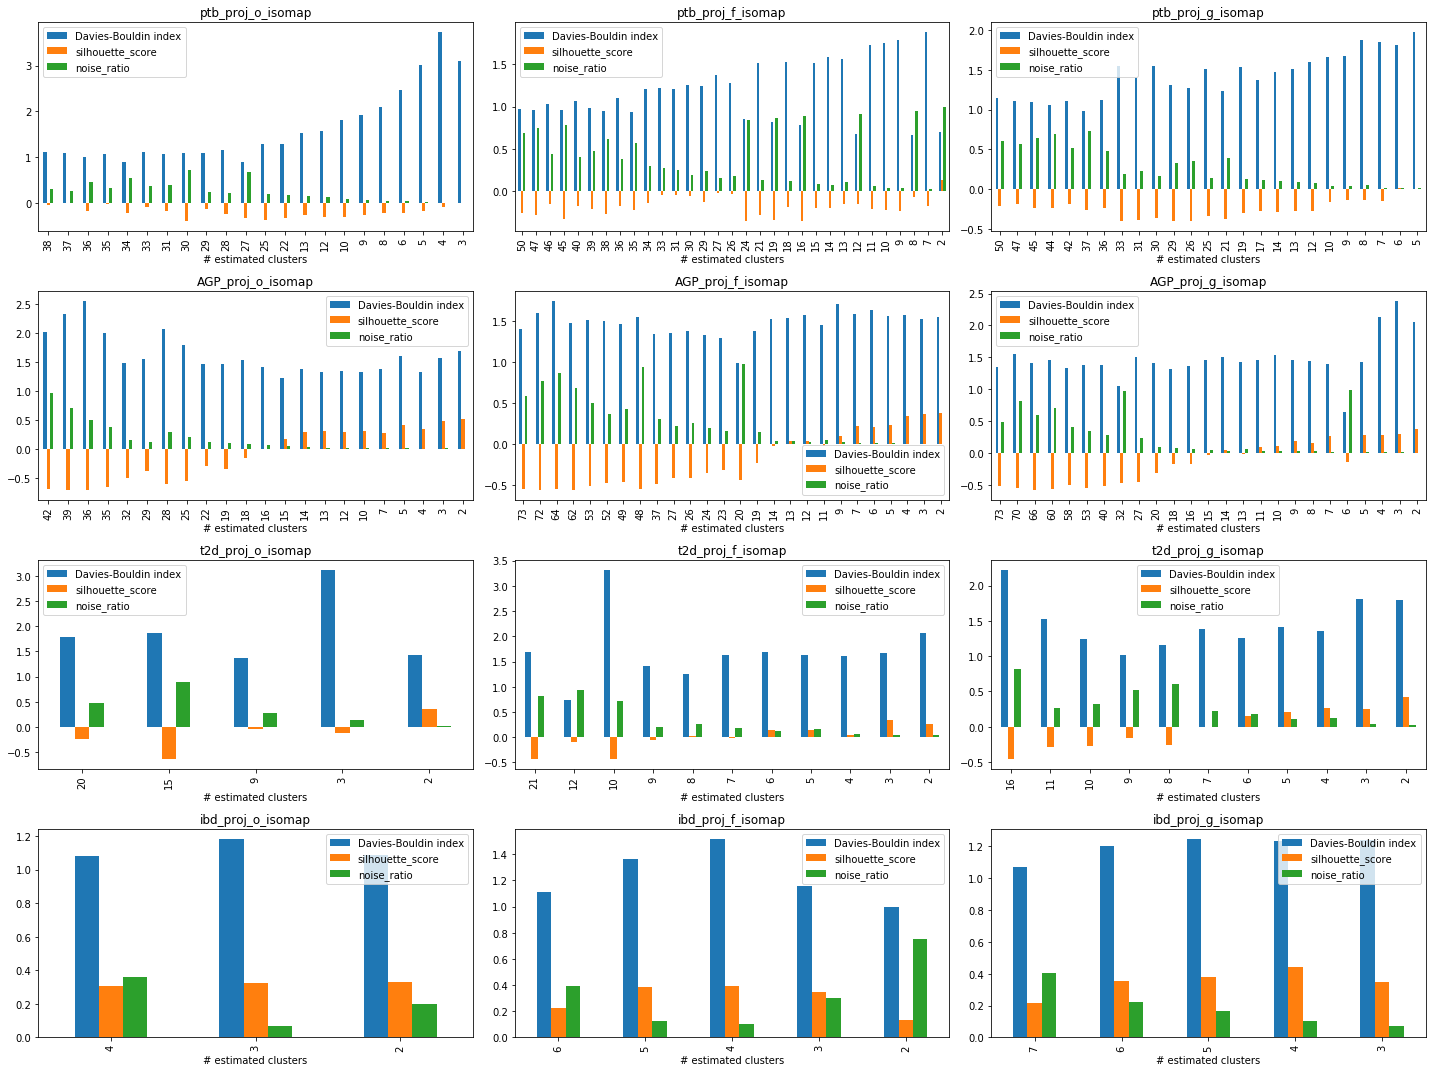

In [55]:
plot_proj_clustering(isomap_cluster_results_list[0], 'isomap')

# KMEANS: ISOMAP

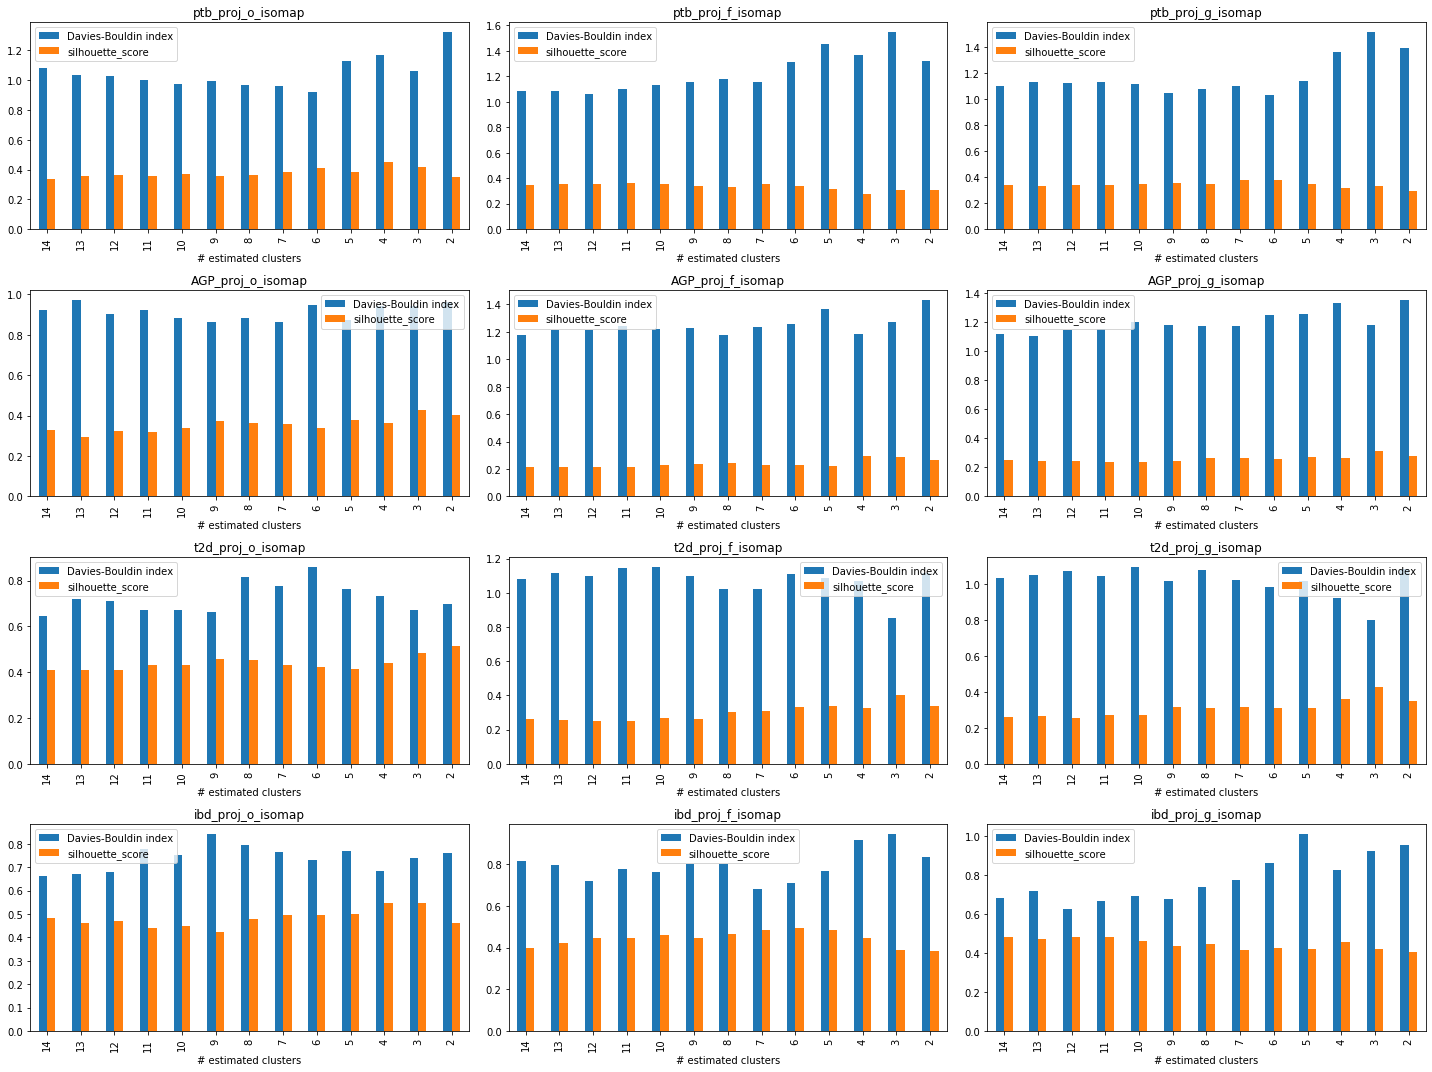

In [56]:
plot_proj_clustering(isomap_cluster_results_list[1], 'isomap')

# SPECTRAL: ISOMAP

In [44]:
# plot_proj_clustering(isomap_cluster_results_list[2])

In [62]:
X_dbind_isomap, X_silh_isomap = create_clustering_pivot_table(copy(isomap_cluster_results_list), methods_names, datasets_names, manifold='isomap', noise_threshold=0.5)

In [63]:
X_dbind_isomap

,AGP_proj_f,AGP_proj_g,AGP_proj_o,ibd_proj_f,ibd_proj_g,ibd_proj_o,ptb_proj_f,ptb_proj_g,ptb_proj_o,t2d_proj_f,t2d_proj_g,t2d_proj_o
dbscan,23.0,18.0,15.0,6.0,7.0,4.0,39.0,36.0,36.0,8.0,10.0,9.0
KMeans,14.0,13.0,7.0,7.0,12.0,14.0,12.0,6.0,6.0,3.0,3.0,14.0


In [64]:
X_silh_isomap

,AGP_proj_f,AGP_proj_g,AGP_proj_o,ibd_proj_f,ibd_proj_g,ibd_proj_o,ptb_proj_f,ptb_proj_g,ptb_proj_o,t2d_proj_f,t2d_proj_g,t2d_proj_o
dbscan,2.0,2.0,2.0,4.0,4.0,2.0,27.0,6.0,37.0,3.0,2.0,2.0
KMeans,4.0,3.0,3.0,6.0,14.0,3.0,11.0,6.0,4.0,3.0,3.0,2.0


# LLE

In [48]:
methods_dict_LLE = {'dbscan':[DBSCAN, np.linspace(0.0001, 1., 50)],
                   'KMeans':[KMeans, np.arange(2, 15, 1)]} # 'SpectralClustering':[SpectralClustering, np.arange(2, 15, 1)]

methods_names = list(methods_dict_LLE.keys())

lle_cluster_results_list = []
for method_name in methods_names:
    method_class, param_range = methods_dict_LLE[method_name]
    cluster_results = clustering(paths_mf_lle, method_class, param_range)
    lle_cluster_results_list.append(cluster_results)

Only one cluster was found for t2d_proj_o_lle, method: DBSCAN param: 0.0001
Only one cluster was found for t2d_proj_o_lle, method: DBSCAN param: 0.02050612244897959
Only one cluster was found for t2d_proj_o_lle, method: DBSCAN param: 0.04091224489795919
Only one cluster was found for t2d_proj_o_lle, method: DBSCAN param: 0.06131836734693878
Only one cluster was found for t2d_proj_o_lle, method: DBSCAN param: 0.08172448979591837
Only one cluster was found for t2d_proj_o_lle, method: DBSCAN param: 0.10213061224489796
Only one cluster was found for t2d_proj_o_lle, method: DBSCAN param: 0.12253673469387756
Only one cluster was found for t2d_proj_o_lle, method: DBSCAN param: 0.14294285714285712
Only one cluster was found for t2d_proj_o_lle, method: DBSCAN param: 0.16334897959183672
Only one cluster was found for t2d_proj_o_lle, method: DBSCAN param: 0.18375510204081633
Only one cluster was found for t2d_proj_o_lle, method: DBSCAN param: 0.2041612244897959
Only one cluster was found for t2d_

Only one cluster was found for AGP_proj_f_lle, method: DBSCAN param: 0.9183755102040816
Only one cluster was found for AGP_proj_f_lle, method: DBSCAN param: 0.9387816326530612
Only one cluster was found for AGP_proj_f_lle, method: DBSCAN param: 0.9591877551020408
Only one cluster was found for AGP_proj_f_lle, method: DBSCAN param: 0.9795938775510205
Only one cluster was found for AGP_proj_f_lle, method: DBSCAN param: 1.0
Only one cluster was found for ibd_proj_g_lle, method: DBSCAN param: 0.0001
Only one cluster was found for ibd_proj_g_lle, method: DBSCAN param: 0.02050612244897959
Only one cluster was found for ibd_proj_g_lle, method: DBSCAN param: 0.04091224489795919
Only one cluster was found for ibd_proj_g_lle, method: DBSCAN param: 0.14294285714285712
Only one cluster was found for ibd_proj_g_lle, method: DBSCAN param: 0.16334897959183672
Only one cluster was found for ibd_proj_g_lle, method: DBSCAN param: 0.18375510204081633
Only one cluster was found for ibd_proj_g_lle, method:

Only one cluster was found for ptb_proj_f_lle, method: DBSCAN param: 0.08172448979591837
Only one cluster was found for ptb_proj_f_lle, method: DBSCAN param: 0.10213061224489796
Only one cluster was found for ptb_proj_f_lle, method: DBSCAN param: 0.12253673469387756
Only one cluster was found for ptb_proj_f_lle, method: DBSCAN param: 0.14294285714285712
Only one cluster was found for ptb_proj_f_lle, method: DBSCAN param: 0.16334897959183672
Only one cluster was found for ptb_proj_f_lle, method: DBSCAN param: 0.18375510204081633
Only one cluster was found for ptb_proj_f_lle, method: DBSCAN param: 0.2041612244897959
Only one cluster was found for ptb_proj_f_lle, method: DBSCAN param: 0.2245673469387755
Only one cluster was found for ptb_proj_f_lle, method: DBSCAN param: 0.2449734693877551
Only one cluster was found for ptb_proj_f_lle, method: DBSCAN param: 0.2653795918367347
Only one cluster was found for ptb_proj_f_lle, method: DBSCAN param: 0.28578571428571425
Only one cluster was foun

Only one cluster was found for t2d_proj_f_lle, method: DBSCAN param: 0.06131836734693878
Only one cluster was found for t2d_proj_f_lle, method: DBSCAN param: 0.08172448979591837
Only one cluster was found for t2d_proj_f_lle, method: DBSCAN param: 0.10213061224489796
Only one cluster was found for t2d_proj_f_lle, method: DBSCAN param: 0.12253673469387756
Only one cluster was found for t2d_proj_f_lle, method: DBSCAN param: 0.14294285714285712
Only one cluster was found for t2d_proj_f_lle, method: DBSCAN param: 0.16334897959183672
Only one cluster was found for t2d_proj_f_lle, method: DBSCAN param: 0.18375510204081633
Only one cluster was found for t2d_proj_f_lle, method: DBSCAN param: 0.2041612244897959
Only one cluster was found for t2d_proj_f_lle, method: DBSCAN param: 0.2245673469387755
Only one cluster was found for t2d_proj_f_lle, method: DBSCAN param: 0.2449734693877551
Only one cluster was found for t2d_proj_f_lle, method: DBSCAN param: 0.2653795918367347
Only one cluster was foun

Only one cluster was found for ibd_proj_o_lle, method: DBSCAN param: 0.16334897959183672
Only one cluster was found for ibd_proj_o_lle, method: DBSCAN param: 0.18375510204081633
Only one cluster was found for ibd_proj_o_lle, method: DBSCAN param: 0.2041612244897959
Only one cluster was found for ibd_proj_o_lle, method: DBSCAN param: 0.2245673469387755
Only one cluster was found for ibd_proj_o_lle, method: DBSCAN param: 0.2449734693877551
Only one cluster was found for ibd_proj_o_lle, method: DBSCAN param: 0.2653795918367347
Only one cluster was found for ibd_proj_o_lle, method: DBSCAN param: 0.28578571428571425
Only one cluster was found for ibd_proj_o_lle, method: DBSCAN param: 0.30619183673469386
Only one cluster was found for ibd_proj_o_lle, method: DBSCAN param: 0.32659795918367346
Only one cluster was found for ibd_proj_o_lle, method: DBSCAN param: 0.34700408163265306
Only one cluster was found for ibd_proj_o_lle, method: DBSCAN param: 0.36741020408163266
Only one cluster was foun

Only one cluster was found for AGP_proj_o_lle, method: DBSCAN param: 0.06131836734693878
Only one cluster was found for AGP_proj_o_lle, method: DBSCAN param: 0.08172448979591837
Only one cluster was found for AGP_proj_o_lle, method: DBSCAN param: 0.10213061224489796
Only one cluster was found for AGP_proj_o_lle, method: DBSCAN param: 0.12253673469387756
Only one cluster was found for AGP_proj_o_lle, method: DBSCAN param: 0.14294285714285712
Only one cluster was found for AGP_proj_o_lle, method: DBSCAN param: 0.16334897959183672
Only one cluster was found for AGP_proj_o_lle, method: DBSCAN param: 0.18375510204081633
Only one cluster was found for AGP_proj_o_lle, method: DBSCAN param: 0.2041612244897959
Only one cluster was found for AGP_proj_o_lle, method: DBSCAN param: 0.2245673469387755
Only one cluster was found for AGP_proj_o_lle, method: DBSCAN param: 0.2449734693877551
Only one cluster was found for AGP_proj_o_lle, method: DBSCAN param: 0.2653795918367347
Only one cluster was foun

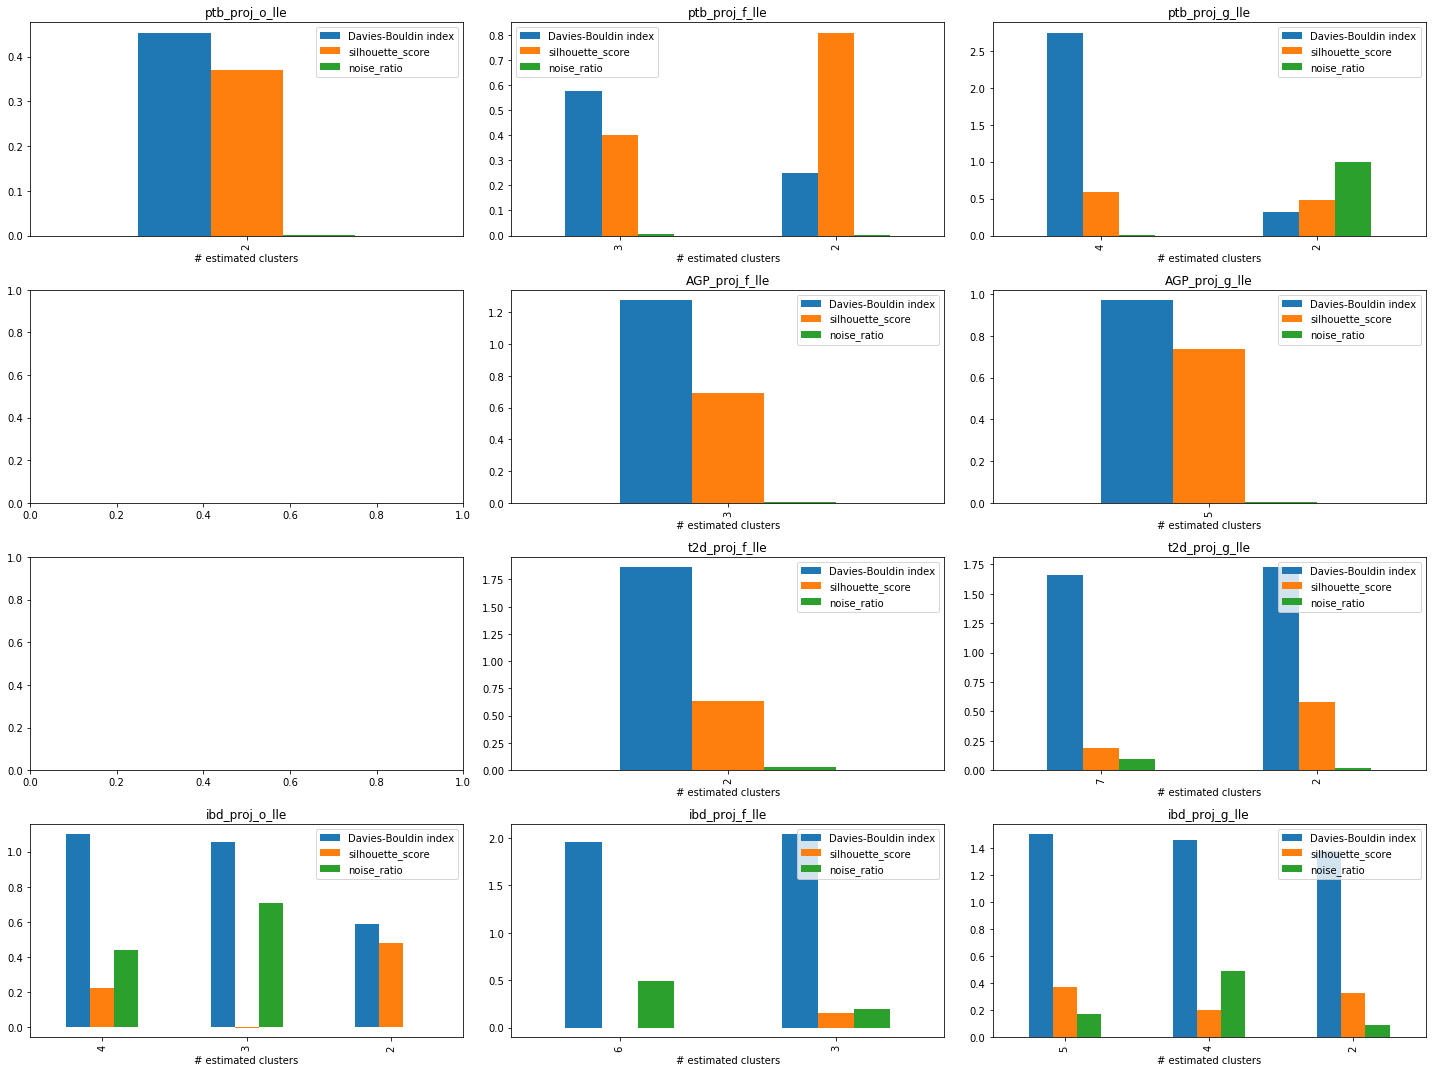

In [57]:
plot_proj_clustering(lle_cluster_results_list[0], 'lle')

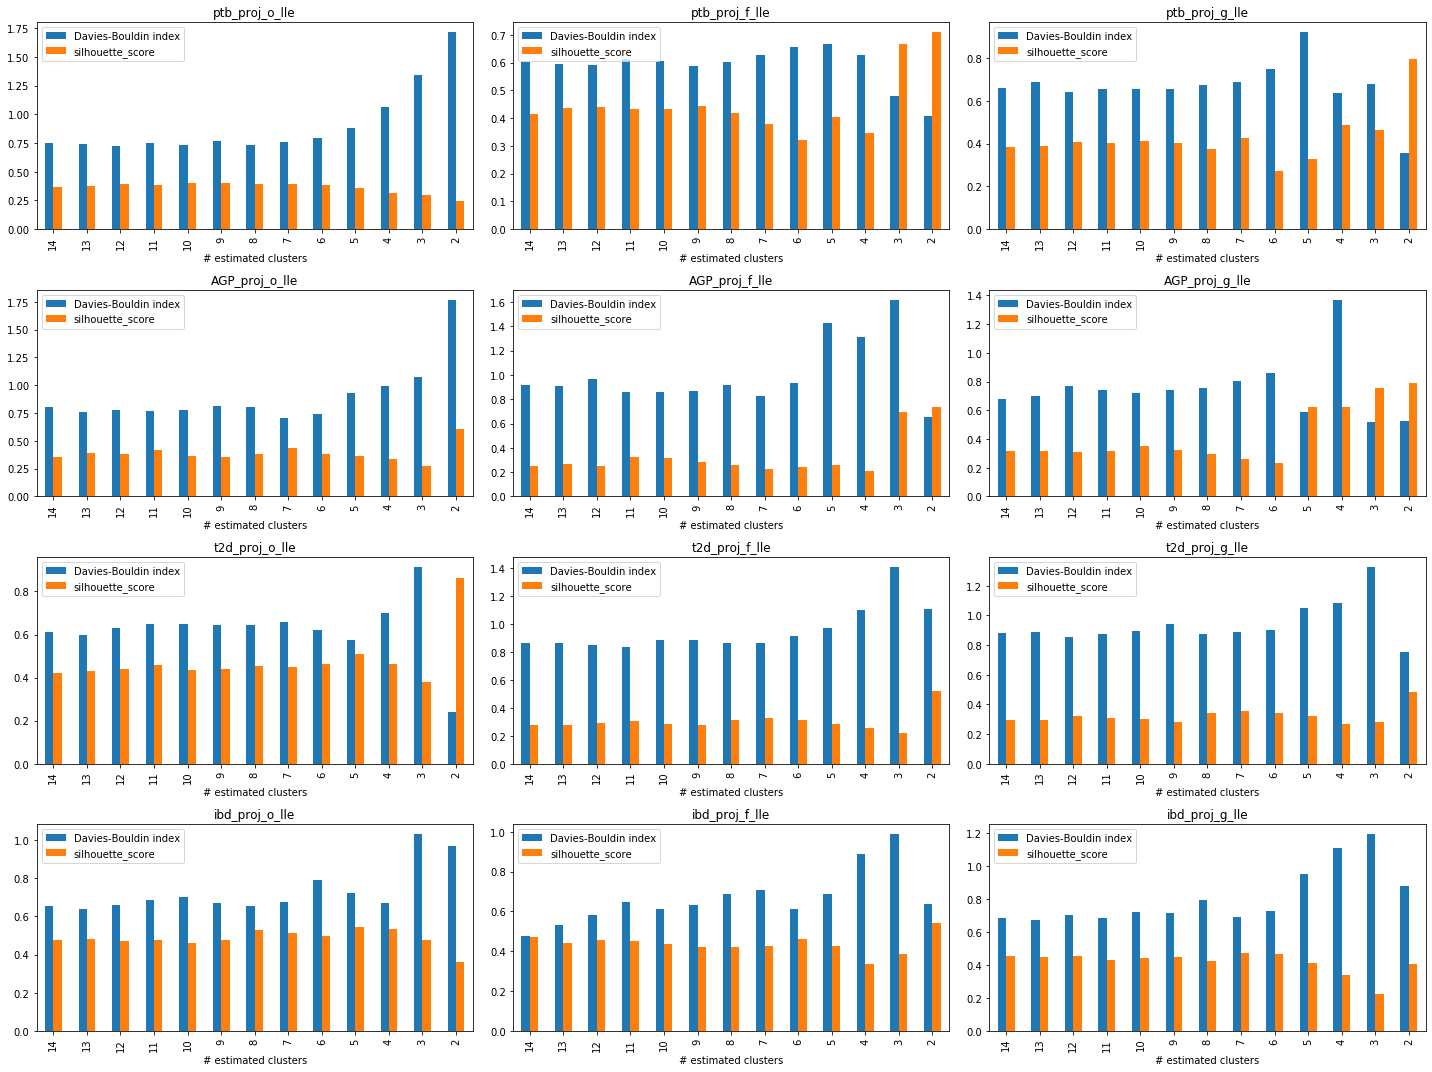

In [58]:
plot_proj_clustering(lle_cluster_results_list[1], 'lle')

In [65]:
X_dbind_lle, X_silh_lle = create_clustering_pivot_table(lle_cluster_results_list, methods_names, datasets_names, manifold='lle')

In [66]:
X_dbind_lle

,AGP_proj_f,AGP_proj_g,AGP_proj_o,ibd_proj_f,ibd_proj_g,ibd_proj_o,ptb_proj_f,ptb_proj_g,ptb_proj_o,t2d_proj_f,t2d_proj_g,t2d_proj_o
dbscan,3.0,5.0,1.0,3.0,2.0,2.0,2.0,4.0,2.0,2.0,7.0,1.0
KMeans,2.0,3.0,7.0,14.0,13.0,13.0,2.0,2.0,12.0,11.0,2.0,2.0


In [67]:
X_silh_lle

,AGP_proj_f,AGP_proj_g,AGP_proj_o,ibd_proj_f,ibd_proj_g,ibd_proj_o,ptb_proj_f,ptb_proj_g,ptb_proj_o,t2d_proj_f,t2d_proj_g,t2d_proj_o
dbscan,3.0,5.0,1.0,3.0,5.0,2.0,2.0,4.0,2.0,2.0,2.0,1.0
KMeans,2.0,2.0,2.0,2.0,7.0,5.0,2.0,2.0,10.0,2.0,2.0,2.0


# Aggregated pivot tables: DBIND

In [68]:
X_dbind_lle.index = [i + '_lle' for i in X_dbind_lle.index]
X_dbind_isomap.index = [i + '_isomap' for i in X_dbind_isomap.index]

In [69]:
X_dbind_all = pd.concat([X_dbind, X_dbind_lle, X_dbind_isomap], axis = 0)
X_dbind_all

,AGP_proj_f,AGP_proj_g,AGP_proj_o,ibd_proj_f,ibd_proj_g,ibd_proj_o,ptb_proj_f,ptb_proj_g,ptb_proj_o,t2d_proj_f,t2d_proj_g,t2d_proj_o
dbscan,15.0,14.0,11.0,5.0,6.0,3.0,18.0,15.0,14.0,5.0,5.0,3.0
KMeans,2.0,3.0,2.0,9.0,13.0,13.0,2.0,2.0,2.0,3.0,3.0,2.0
dbscan_lle,3.0,5.0,1.0,3.0,2.0,2.0,2.0,4.0,2.0,2.0,7.0,1.0
KMeans_lle,2.0,3.0,7.0,14.0,13.0,13.0,2.0,2.0,12.0,11.0,2.0,2.0
dbscan_isomap,23.0,18.0,15.0,6.0,7.0,4.0,39.0,36.0,36.0,8.0,10.0,9.0
KMeans_isomap,14.0,13.0,7.0,7.0,12.0,14.0,12.0,6.0,6.0,3.0,3.0,14.0


# Aggregated pivot tables: SILHOETTE

In [70]:
X_silh_lle.index = [i + '_lle' for i in X_silh_lle.index]
X_silh_isomap.index = [i + '_isomap' for i in X_silh_isomap.index]
X_silh_all = pd.concat([X_silh, X_silh_lle, X_silh_isomap], axis = 0)
X_silh_all

,AGP_proj_f,AGP_proj_g,AGP_proj_o,ibd_proj_f,ibd_proj_g,ibd_proj_o,ptb_proj_f,ptb_proj_g,ptb_proj_o,t2d_proj_f,t2d_proj_g,t2d_proj_o
dbscan,2.0,2.0,2.0,4.0,6.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0
KMeans,4.0,3.0,3.0,9.0,5.0,4.0,13.0,7.0,8.0,3.0,3.0,2.0
dbscan_lle,3.0,5.0,1.0,3.0,5.0,2.0,2.0,4.0,2.0,2.0,2.0,1.0
KMeans_lle,2.0,2.0,2.0,2.0,7.0,5.0,2.0,2.0,10.0,2.0,2.0,2.0
dbscan_isomap,2.0,2.0,2.0,4.0,4.0,2.0,27.0,6.0,37.0,3.0,2.0,2.0
KMeans_isomap,4.0,3.0,3.0,6.0,14.0,3.0,11.0,6.0,4.0,3.0,3.0,2.0


# Visualisation 2D PCA

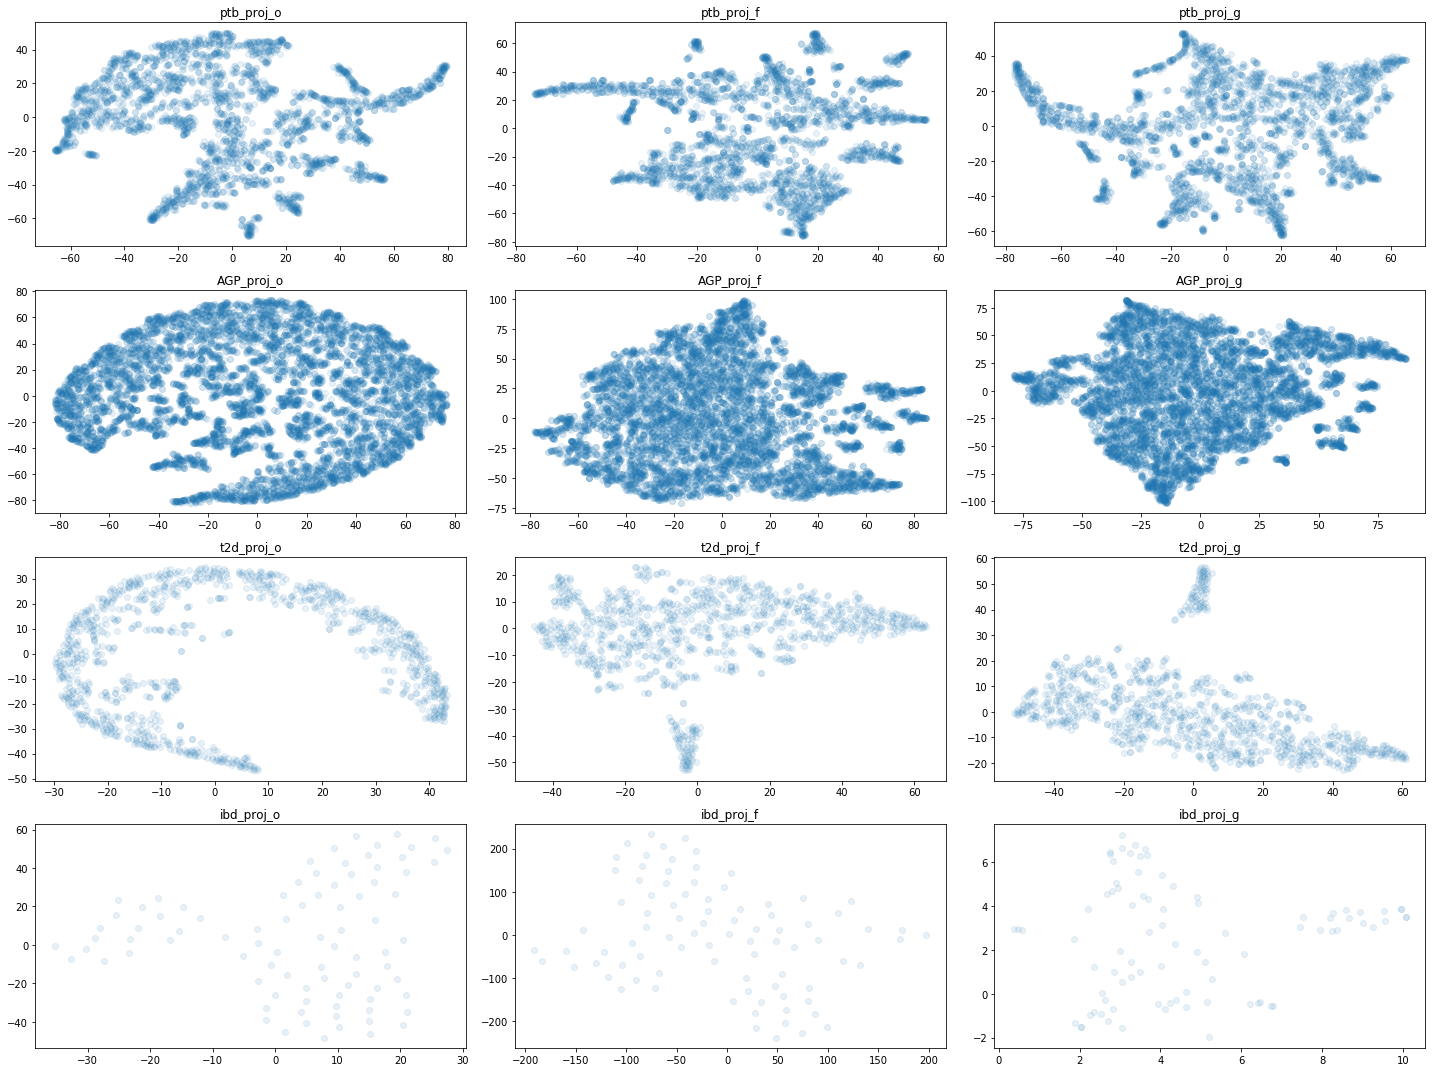

In [73]:
from sklearn.manifold import TSNE
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20,15))
for i,dataset_name in tqdm_notebook(enumerate(['ptb', 'AGP', 't2d', 'ibd'])):
    for j,tax_name in enumerate(['o', 'f', 'g']):
        label = '_'.join([dataset_name, 'proj', tax_name])
        path = label2path[label]
        dataset = np.genfromtxt(path, delimiter=';')
        tsne2 = TSNE(2)
        tsne2.fit(dataset)
        axes[i,j].scatter(tsne2.embedding_[:,0], tsne2.embedding_[:,1], alpha=0.1)
        axes[i,j].set_title(label)
plt.tight_layout()
plt.show()

# Visualisation 2D ISOMAP

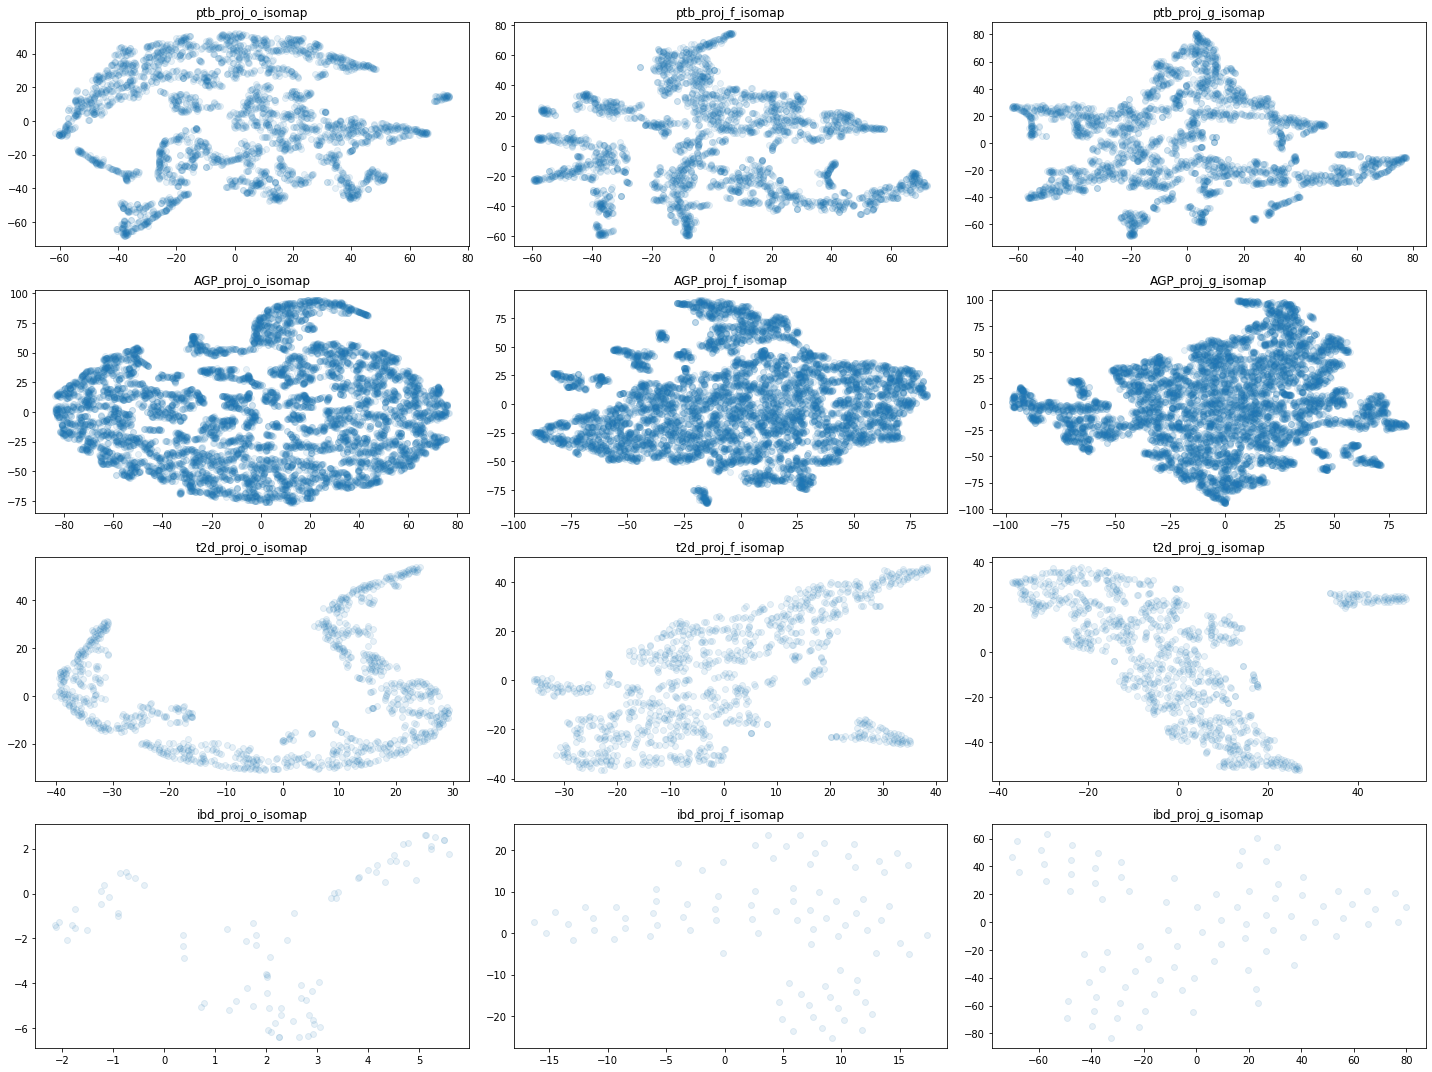

In [75]:
from sklearn.manifold import TSNE
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20,15))
for i,dataset_name in tqdm_notebook(enumerate(['ptb', 'AGP', 't2d', 'ibd'])):
    for j,tax_name in enumerate(['o', 'f', 'g']):
        label = '_'.join([dataset_name, 'proj', tax_name, 'isomap'])
        path = label2path[label]
        dataset = np.genfromtxt(path, delimiter=';')
        tsne2 = TSNE(2)
        tsne2.fit(dataset)
        axes[i,j].scatter(tsne2.embedding_[:,0], tsne2.embedding_[:,1], alpha=0.1)
        axes[i,j].set_title(label)
plt.tight_layout()
plt.show()

# Visualisation 2D LLE

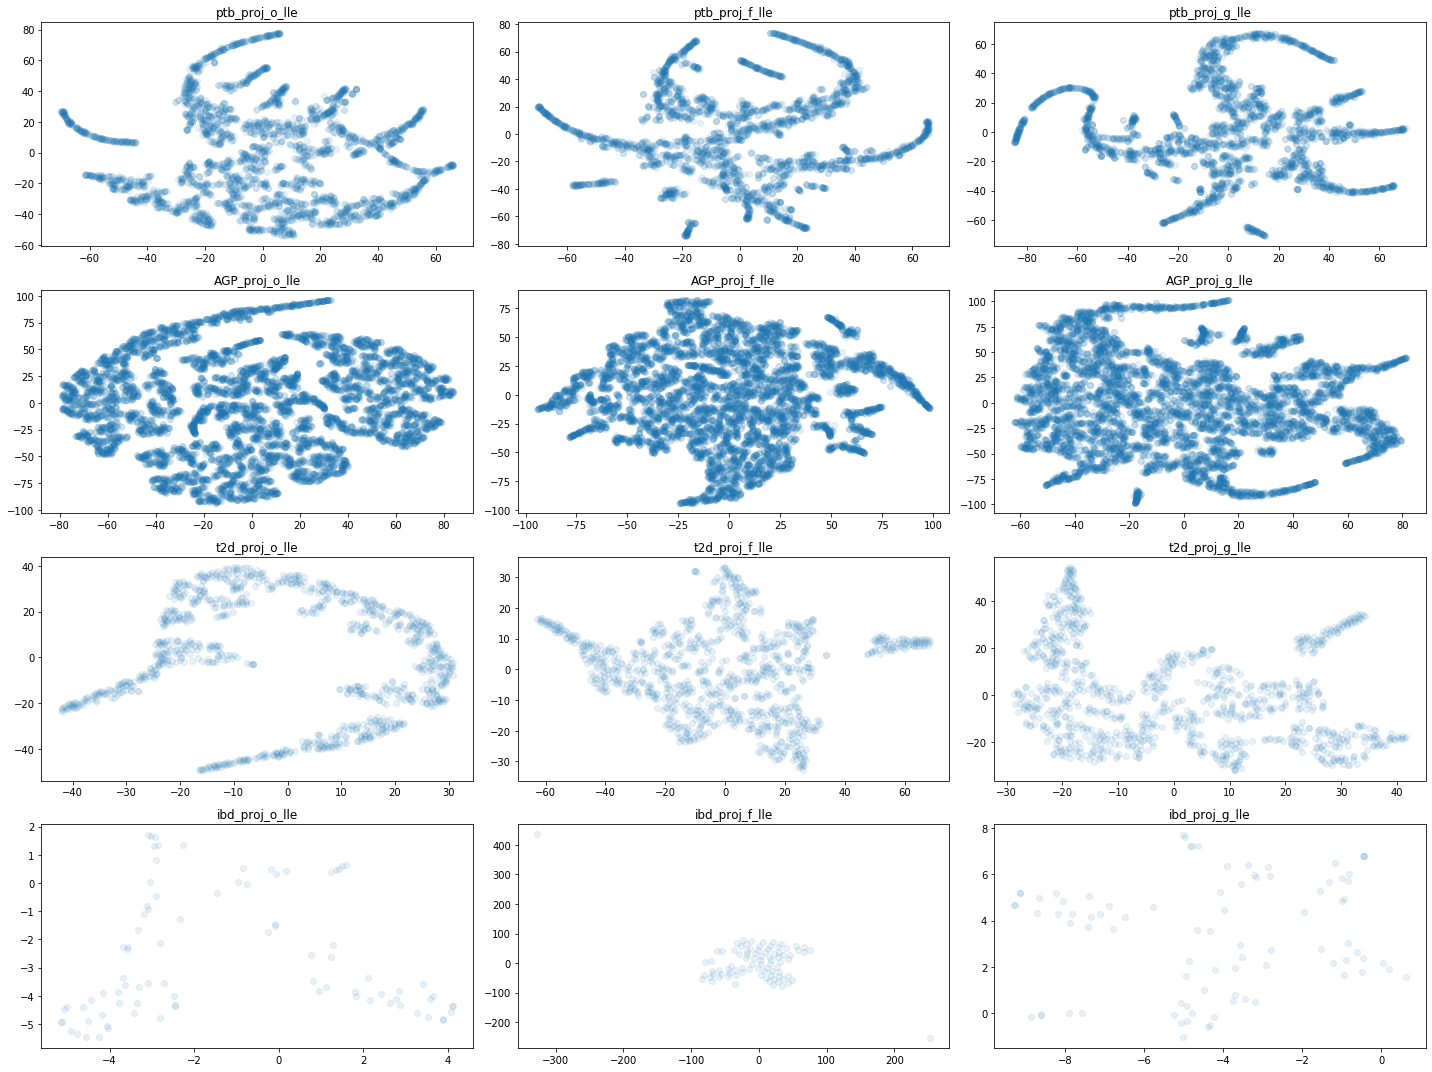

In [76]:
from sklearn.manifold import TSNE
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20,15))
d
        tsne2 = TSNE(2)
        tsne2.fit(dataset)
        axes[i,j].scatter(tsne2.embedding_[:,0], tsne2.embedding_[:,1], alpha=0.1)
        axes[i,j].set_title(label)
plt.tight_layout()
plt.show()